Nutrient comparison using Rich's dataset. (all of it)

In [13]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools
from matplotlib.colors import LinearSegmentedColormap
import os
%matplotlib inline

In [60]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [20]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [4]:
nutrients_2015 = sio.loadmat('/ocean/rich/home/metro/venus_adcp/matlabPSF/PSFbottledata.mat')

In [5]:
nutrients_data = nutrients_2015[list(nutrients_2015.keys())[3]]
n_dtype = nutrients_data.dtype
n_data = {n: nutrients_data[n][0, 0] for n in n_dtype.names}
n_times = n_data['mtime'][:,0]
print(n_times.shape)

(896,)


In [6]:
n_lons = n_data['lon'][:,0]
n_lats = n_data['lat'][:,0]
n_si = n_data['si'][:,0]
n_no23 = n_data['no23'][:,0]
n_depths = n_data['depth'][:,0]

In [7]:
base = datetime.datetime(2000, 1, 1)
py_n_times = np.array([base for i in range(896)])
print(py_n_times.shape)
for m in range(896):
    a  =  (datetime.datetime.fromordinal(int(n_times[m])) 
           + datetime.timedelta(days=int(n_times[m])%1) 
           - datetime.timedelta(days = 366))
    py_n_times[m] = a

(896,)


In [9]:
n_depths[n_depths == 2] = 0.5

In [11]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [39]:
list_of_model_si = np.ma.masked_array(np.zeros((896)), mask = True)
list_of_model_ni = np.ma.masked_array(np.zeros((896)), mask = True)
for n in range(896):
    Yind, Xind = geo_tools.find_closest_model_point(n_lons[n], 
                                                    n_lats[n], 
                                                    X, Y, land_mask = bathy.mask)
    date = py_n_times[n]
    sub_dir = date.strftime('%d%b%y').lower()
    datestr = date.strftime('%Y%m%d')
    fname = 'SalishSea_1d_{}_{}_ptrc_T.nc'.format(datestr, datestr)
    nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
    
    if ((n_depths[n] == 20) and (mesh.variables['tmask'][0,18,Yind,Xind] == 1)):
        si_val = nuts.variables['silicon'][0, 18, Yind, Xind]
        ni_val = nuts.variables['nitrate'][0, 18, Yind, Xind]
        list_of_model_si.mask[n] = False
        list_of_model_si[n] = si_val
        list_of_model_ni.mask[n] = False
        list_of_model_ni[n] = ni_val
    elif ((n_depths[n] == 0) and (mesh.variables['tmask'][0,0,Yind,Xind] == 1)):
        si_val = nuts.variables['silicon'][0, 0, Yind, Xind]
        ni_val = nuts.variables['nitrate'][0, 0, Yind, Xind]
        list_of_model_si.mask[n] = False
        list_of_model_si[n] = si_val
        list_of_model_ni.mask[n] = False
        list_of_model_ni[n] = ni_val

In [40]:
n_si = np.ma.masked_array(n_si, list_of_model_si.mask)
n_no23 = np.ma.masked_array(n_no23, list_of_model_ni.mask)

In [46]:
np.ma.count(n_si)

881

In [48]:
np.ma.count(list_of_model_ni)

881

bias =  -1.40580447732
RMSE = 6.14120584773
Willmott = 0.885346017556


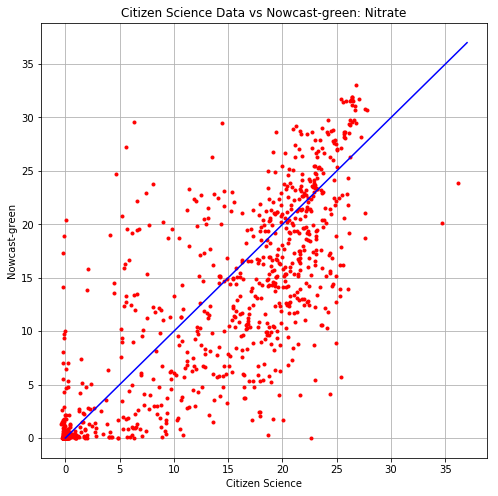

In [50]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(n_no23, list_of_model_ni, 'r.')
ax.plot(np.arange(0,38), np.arange(0,38), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Nitrate')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(n_no23) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - n_no23)**2) /881)))
xbar = np.mean(n_no23)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - n_no23)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(n_no23 - xbar))**2))))

bias =  -10.0621294426
RMSE = 16.3001346333
Willmott = 0.742862208423


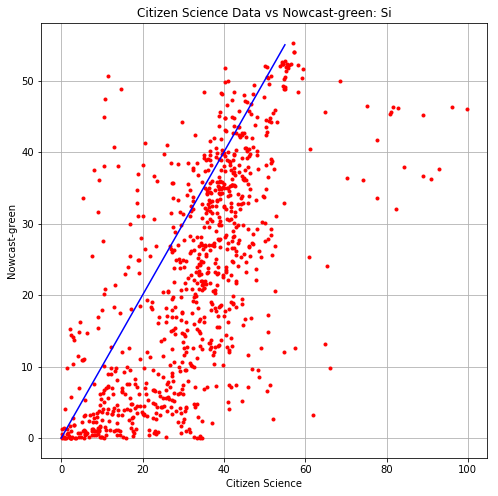

In [51]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(n_si, list_of_model_si, 'r.')
ax.plot(np.arange(0,56), np.arange(0,56), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Si')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(n_si) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - n_si)**2) /881)))
xbar = np.mean(n_si)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - n_si)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(n_si - xbar))**2))))

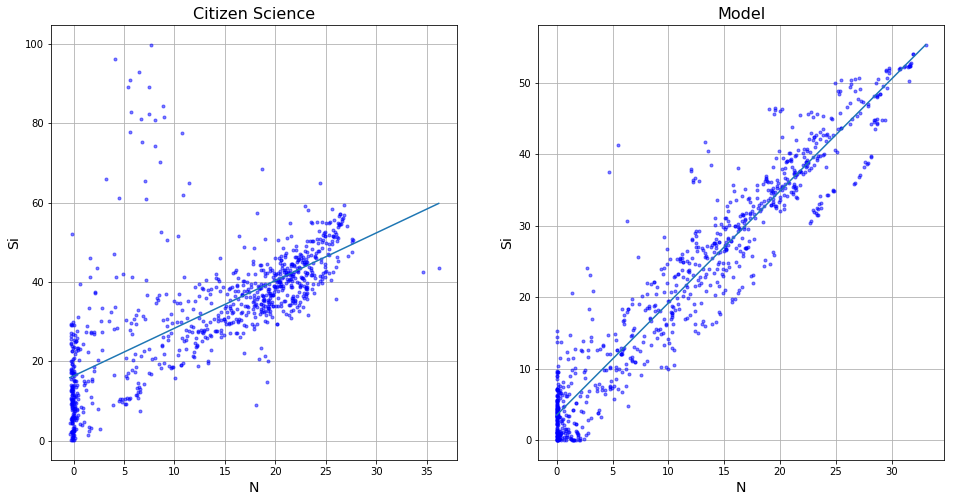

In [54]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].plot(n_no23, n_si, 'b.', alpha = 0.5)
ax[0].plot(np.unique(n_no23), np.poly1d(np.polyfit(n_no23, n_si, 1))(np.unique(n_no23)))
x = np.arange(0,37)
#ax[0].plot(x,x, 'r-', alpha = 0.3)
#ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[1].plot(list_of_model_ni, list_of_model_si, 'b.', alpha = 0.5)
ax[1].plot(np.unique(list_of_model_ni), 
           np.poly1d(np.polyfit(list_of_model_ni, list_of_model_si, 1))(np.unique(list_of_model_ni)))
x = np.arange(0,53)
#ax[1].plot(x,x, 'r-', alpha = 0.3, label = 'slope = 1')
#ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
#plt.legend();

In [57]:
m1, b1 = np.polyfit(n_no23, n_si, 1)
print('CitSci slope = ' + str(m1))
print('CitSci y int = ' + str(b1))
m2, b2 = np.polyfit(list_of_model_ni, list_of_model_si, 1)
print('model slope = ' + str(m2))
print('model y int = ' + str(b2))

CitSci slope = 1.20096637703
CitSci y int = 16.2945648357
model slope = 1.566891853
model y int = 3.50480573495


In [64]:
py_n_times[(py_n_times > datetime.datetime(2015,1,31)) & (py_n_times < datetime.datetime(2015,5,3))].shape

(314,)